In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/nk/nkfinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: RHUM
Index: 1, Column Name: MAX
Index: 2, Column Name: MIN
Index: 3, Column Name: TEMP
Index: 4, Column Name: WDSP


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/nk/rynk.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RHUM    365 non-null    float64
 1   MAX     365 non-null    float64
 2   MIN     365 non-null    float64
 3   TEMP    365 non-null    float64
 4   WDSP    365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [4]:
df_train = df["2002-01-01":"2019-12-31"]
df_valid = df["2020-01-01":"2023-12-31"]
df_test = df["2024-01-01":"2024-12-31"]

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

def split_inputs_and_targets(time_series):
    ahead = 365
    target_cols = tf.constant([1, 2, 3], dtype=tf.int32)
    X = time_series[:, :-ahead]
    Y = tf.gather(time_series[:, -ahead:], target_cols, axis=-1)
    return X, Y


seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df_test = df_test.drop(pd.to_datetime("2024-02-29"))

X = df_valid.to_numpy()[np.newaxis, :seq_length]
Y_test = df_test.iloc[:, [1, 2, 3]].to_numpy()

Y_ref = ry.iloc[:, [1, 2, 3]].to_numpy()

mae_ref = mean_absolute_error(Y_test[:, 2], Y_ref[:, 2])
print(f'Mean Absolute Error (MAE): {mae_ref:.3f}')

rmse_ref = np.sqrt(mean_squared_error(Y_test[:, 2], Y_ref[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_ref:.3f}')

Mean Absolute Error (MAE): 3.687
Root Mean Squared Error (RMSE): 4.775


In [7]:
lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_32 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_32.save('models/lstm_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 197.2349 - mae: 11.4803 - val_loss: 133.4188 - val_mae: 9.0143
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 105.3633 - mae: 8.1186 - val_loss: 88.3318 - val_mae: 7.4436
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 74.4829 - mae: 6.9952 - val_loss: 71.4526 - val_mae: 6.9216
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 63.7529 - mae: 6.6066 - val_loss: 65.1620 - val_mae: 6.7262
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 60.0225 - mae: 6.4616 - val_loss: 62.5274 - val_mae: 6.6290
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 58.3508 - mae: 6.3820 - val_loss: 61.0424 - val_mae: 6.5593
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 57.2269 - mae: 6.3189 - val_loss: 59.8776 - val_mae: 6.4950
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 56.2215 - mae: 6.2599 - val_loss: 58.8456 - val_mae: 6.4349
Epoch 9/80
183/183 ━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_2 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 13.2942 - mae: 2.8493 - val_loss: 14.3974 - val_mae: 3.0277
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.2607 - mae: 2.8458 - val_loss: 13.9214 - val_mae: 2.9754
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.2248 - mae: 2.8421 - val_loss: 14.1712 - val_mae: 3.0028
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 13.2174 - mae: 2.8413 - val_loss: 13.7931 - val_mae: 2.9617
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.2197 - mae: 2.8416 - val_loss: 14.2009 - val_mae: 3.0050
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 13.2100 - mae: 2.8408 - val_loss: 13.7162 - val_mae: 2.9519
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 13.1467 - mae: 2.8333 - val_loss: 13.6963 - val_mae: 2.9510
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.1583 - mae: 2.8347 - val_loss: 13.5969 - val_mae: 2.9387
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [10]:
lstm_32 = tf.keras.models.load_model('models/lstm_32.keras')

Y_lstm_32 = lstm_32.predict(X)  # shape: (1, 365, 3)
Y_lstm_32 = Y_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_32_pred.csv')

mae_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_32:.3f}')

rmse_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Mean Absolute Error (MAE): 3.126
Root Mean Squared Error (RMSE): 3.824


In [11]:
conv_lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_32 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 194.9002 - mae: 11.3927 - val_loss: 132.1068 - val_mae: 8.9657
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 105.0879 - mae: 8.1222 - val_loss: 89.7199 - val_mae: 7.5422
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 76.5289 - mae: 7.1285 - val_loss: 75.0199 - val_mae: 7.1371
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 67.7484 - mae: 6.8457 - val_loss: 70.4322 - val_mae: 7.0304
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.5293 - mae: 6.7819 - val_loss: 69.1458 - val_mae: 7.0095
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.0485 - mae: 6.7716 - val_loss: 68.7927 - val_mae: 7.0065
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.9483 - mae: 6.7691 - val_loss: 68.6972 - val_mae: 7.0059
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.9555 - mae: 6.7707 - val_loss: 68.6685 - val_mae: 7.0055
Epoch 9/60
183/183 ━━━━━━━━━

In [12]:
from tensorflow.keras.models import load_model
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_2 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 13.3006 - mae: 2.8532 - val_loss: 13.8207 - val_mae: 2.9669
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 13.1568 - mae: 2.8366 - val_loss: 13.3977 - val_mae: 2.9205
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 13.0331 - mae: 2.8224 - val_loss: 13.2713 - val_mae: 2.9073
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.9563 - mae: 2.8139 - val_loss: 13.2219 - val_mae: 2.9001
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 12.8931 - mae: 2.8065 - val_loss: 13.1265 - val_mae: 2.8908
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.8290 - mae: 2.7995 - val_loss: 13.0660 - val_mae: 2.8811
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.7924 - mae: 2.7953 - val_loss: 12.9757 - val_mae: 2.8709
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.7582 - mae: 2.7914 - val_loss: 12.8553 - val_mae: 2.8592
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [14]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_3 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.6717 - mae: 2.7812 - val_loss: 12.6454 - val_mae: 2.8341
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.6532 - mae: 2.7790 - val_loss: 12.8314 - val_mae: 2.8528
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.6173 - mae: 2.7752 - val_loss: 12.6144 - val_mae: 2.8293
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.5961 - mae: 2.7727 - val_loss: 12.6814 - val_mae: 2.8352
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.5665 - mae: 2.7692 - val_loss: 12.9136 - val_mae: 2.8615
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.5289 - mae: 2.7649 - val_loss: 12.5119 - val_mae: 2.8141
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 12.4986 - mae: 2.7614 - val_loss: 12.6613 - val_mae: 2.8306
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.4705 - mae: 2.7586 - val_loss: 12.5994 - val_mae: 2.8226
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [16]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_4 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 12.3590 - mae: 2.7464 - val_loss: 12.6138 - val_mae: 2.8227
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.3102 - mae: 2.7406 - val_loss: 12.9257 - val_mae: 2.8596
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.3125 - mae: 2.7410 - val_loss: 12.6439 - val_mae: 2.8258
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.2621 - mae: 2.7352 - val_loss: 12.5523 - val_mae: 2.8159
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.2558 - mae: 2.7346 - val_loss: 12.2674 - val_mae: 2.7808
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.2390 - mae: 2.7320 - val_loss: 12.4586 - val_mae: 2.8055
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.2170 - mae: 2.7295 - val_loss: 12.4922 - val_mae: 2.8083
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.1701 - mae: 2.7239 - val_loss: 12.7016 - val_mae: 2.8323
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [17]:
conv_lstm_32 = tf.keras.models.load_model('models/conv_lstm_32.keras')

Y_conv_lstm_32 = conv_lstm_32.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_32 = Y_conv_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_32_pred.csv')

mae_conv_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_32:.3f}')

rmse_conv_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Mean Absolute Error (MAE): 3.079
Root Mean Squared Error (RMSE): 3.750


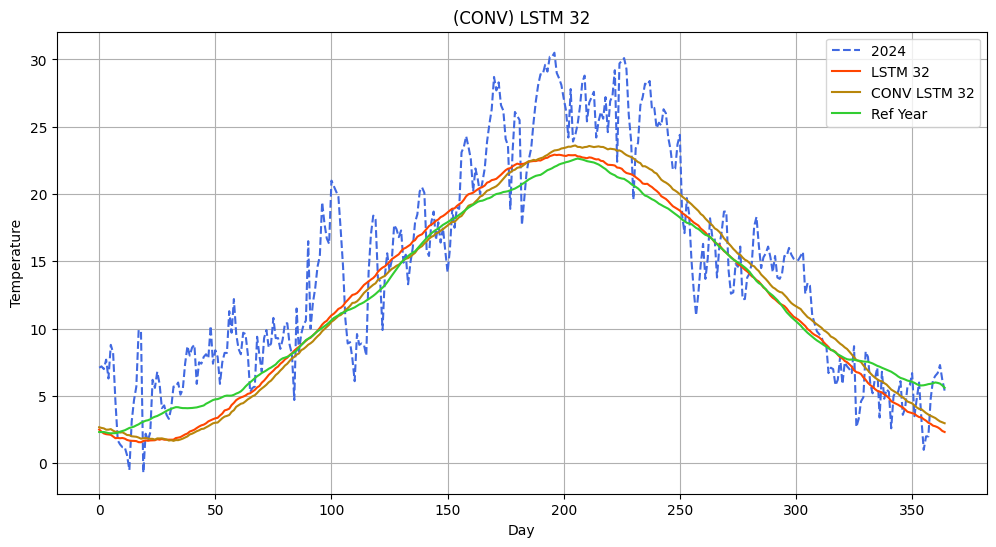

In [18]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_32[:, 2], label="LSTM 32", color='orangered')
plt.plot(x, Y_conv_lstm_32[:, 2], label="CONV LSTM 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [19]:
lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_64 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_64.save('models/lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 173.6318 - mae: 10.6181 - val_loss: 87.5139 - val_mae: 7.4647
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.3024 - mae: 6.9663 - val_loss: 67.9762 - val_mae: 6.8989
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 62.9065 - mae: 6.6347 - val_loss: 65.1633 - val_mae: 6.7985
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 61.1649 - mae: 6.5487 - val_loss: 63.7988 - val_mae: 6.7240
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 60.0193 - mae: 6.4812 - val_loss: 62.5498 - val_mae: 6.6516
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 58.8979 - mae: 6.4159 - val_loss: 61.6443 - val_mae: 6.5943
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 57.8117 - mae: 6.3515 - val_loss: 60.3752 - val_mae: 6.5213
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 56.7793 - mae: 6.2878 - val_loss: 59.4392 - val_mae: 6.4652
Epoch 9/60
183/183 ━━━━━━━━━━

In [21]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_2 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 14.9826 - mae: 3.0358 - val_loss: 15.0836 - val_mae: 3.1028
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 14.8150 - mae: 3.0185 - val_loss: 15.5238 - val_mae: 3.1458
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 14.6347 - mae: 2.9994 - val_loss: 16.1639 - val_mae: 3.2065
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 14.6163 - mae: 2.9973 - val_loss: 14.9617 - val_mae: 3.0877
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 14.4375 - mae: 2.9777 - val_loss: 14.7527 - val_mae: 3.0623
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 14.5378 - mae: 2.9881 - val_loss: 16.0878 - val_mae: 3.1923
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 14.4531 - mae: 2.9785 - val_loss: 15.0677 - val_mae: 3.0982
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 14.2869 - mae: 2.9610 - val_loss: 14.3447 - val_mae: 3.0275
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [23]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_3 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 14.1318 - mae: 2.9436 - val_loss: 14.2323 - val_mae: 3.0112
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 14.1672 - mae: 2.9484 - val_loss: 14.6246 - val_mae: 3.0517
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.8741 - mae: 2.9166 - val_loss: 15.6903 - val_mae: 3.1530
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 13.8147 - mae: 2.9096 - val_loss: 14.5594 - val_mae: 3.0394
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.7261 - mae: 2.9000 - val_loss: 14.5014 - val_mae: 3.0332
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.7103 - mae: 2.8988 - val_loss: 14.7981 - val_mae: 3.0649
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.7455 - mae: 2.9017 - val_loss: 14.7360 - val_mae: 3.0565
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.7326 - mae: 2.9009 - val_loss: 14.0027 - val_mae: 2.9835
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [25]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_4 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 13.5316 - mae: 2.8777 - val_loss: 13.7102 - val_mae: 2.9484
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.4659 - mae: 2.8702 - val_loss: 13.8453 - val_mae: 2.9679
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.5183 - mae: 2.8762 - val_loss: 14.1256 - val_mae: 2.9967
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.3503 - mae: 2.8580 - val_loss: 14.5807 - val_mae: 3.0470
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.3105 - mae: 2.8530 - val_loss: 13.6492 - val_mae: 2.9463
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.3248 - mae: 2.8554 - val_loss: 14.3906 - val_mae: 3.0235
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 13.3815 - mae: 2.8605 - val_loss: 14.5627 - val_mae: 3.0434
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 13.3372 - mae: 2.8558 - val_loss: 13.7420 - val_mae: 2.9535
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [27]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_5 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 13.1017 - mae: 2.8287 - val_loss: 14.9672 - val_mae: 3.0819
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 13.2269 - mae: 2.8444 - val_loss: 13.8640 - val_mae: 2.9643
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.0505 - mae: 2.8233 - val_loss: 14.0814 - val_mae: 2.9862
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.0133 - mae: 2.8189 - val_loss: 14.1403 - val_mae: 2.9952
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.9910 - mae: 2.8164 - val_loss: 14.4869 - val_mae: 3.0350
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 13.0738 - mae: 2.8262 - val_loss: 14.1609 - val_mae: 2.9967
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.9082 - mae: 2.8075 - val_loss: 13.8925 - val_mae: 2.9666
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.9509 - mae: 2.8128 - val_loss: 13.8504 - val_mae: 2.9612
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [7]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_6 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 12.8022 - mae: 2.7951 - val_loss: 14.1298 - val_mae: 2.9952
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 12.7779 - mae: 2.7930 - val_loss: 14.2988 - val_mae: 3.0001
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.8708 - mae: 2.8024 - val_loss: 14.0623 - val_mae: 2.9859
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.7110 - mae: 2.7847 - val_loss: 13.5559 - val_mae: 2.9277
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.7038 - mae: 2.7836 - val_loss: 13.5494 - val_mae: 2.9261
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.7852 - mae: 2.7932 - val_loss: 14.0548 - val_mae: 2.9838
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.7368 - mae: 2.7872 - val_loss: 15.0795 - val_mae: 3.0830
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 12.6285 - mae: 2.7743 - val_loss: 14.0504 - val_mae: 2.9803
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [8]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')

Y_lstm_64 = lstm_64.predict(X)  # shape: (1, 365, 3)
Y_lstm_64 = Y_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_64_pred.csv')

mae_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_64:.3f}')

rmse_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Mean Absolute Error (MAE): 3.318
Root Mean Squared Error (RMSE): 4.044


In [29]:
conv_lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_64 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 172.3175 - mae: 10.5702 - val_loss: 88.9109 - val_mae: 7.5198
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 73.6730 - mae: 7.0357 - val_loss: 70.3281 - val_mae: 7.0289
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.3340 - mae: 6.7761 - val_loss: 68.8211 - val_mae: 7.0078
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 65.0282 - mae: 6.7733 - val_loss: 68.6974 - val_mae: 7.0070
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 64.9877 - mae: 6.7720 - val_loss: 68.6958 - val_mae: 7.0065
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 65.0131 - mae: 6.7733 - val_loss: 68.6895 - val_mae: 7.0069
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 64.9643 - mae: 6.7706 - val_loss: 68.7050 - val_mae: 7.0073
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0279 - mae: 6.7739 - val_loss: 68.7316 - val_mae: 7.0081
Epoch 9/60
183/183 ━━━━━━━━━━━

In [30]:
conv_lstm_64 = tf.keras.models.load_model('models/conv_lstm_64.keras')

Y_conv_lstm_64 = conv_lstm_64.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_64 = Y_conv_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_64_pred.csv')

mae_conv_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_64:.3f}')

rmse_conv_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Mean Absolute Error (MAE): 3.077
Root Mean Squared Error (RMSE): 3.751


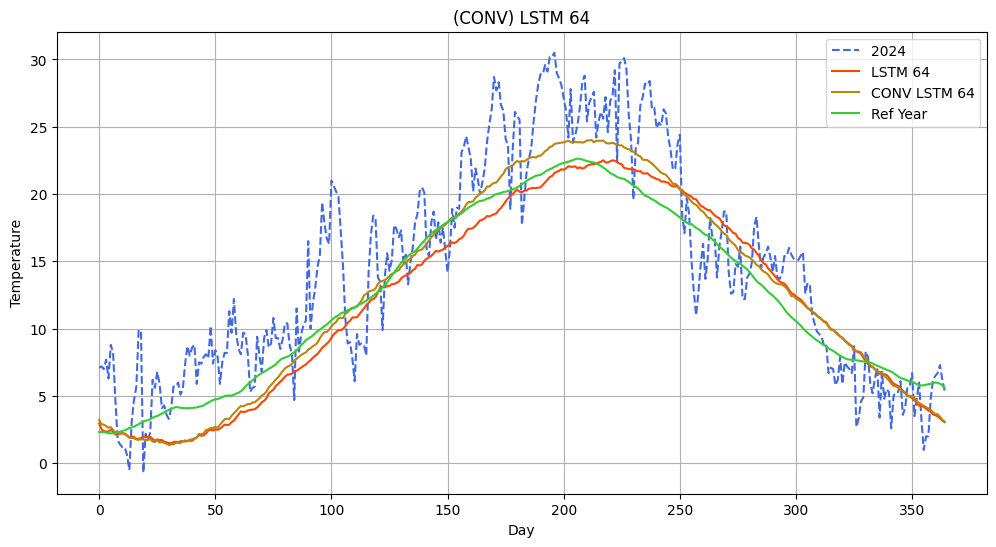

In [31]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_64[:, 2], label="LSTM 64", color='orangered')
plt.plot(x, Y_conv_lstm_64[:, 2], label="CONV LSTM 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [32]:
lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_128.save('models/lstm_128.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 145.5756 - mae: 9.6027 - val_loss: 69.5781 - val_mae: 7.0162
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0654 - mae: 6.7721 - val_loss: 68.7351 - val_mae: 7.0088
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 65.0886 - mae: 6.7777 - val_loss: 68.7477 - val_mae: 7.0088
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 65.0019 - mae: 6.7728 - val_loss: 68.7408 - val_mae: 7.0085
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0104 - mae: 6.7729 - val_loss: 68.7718 - val_mae: 7.0097
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0886 - mae: 6.7771 - val_loss: 68.7685 - val_mae: 7.0071
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 64.6633 - mae: 6.7525 - val_loss: 66.8371 - val_mae: 6.8991
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 62.7104 - mae: 6.6372 - val_loss: 64.1641 - val_mae: 6.7411
Epoch 9/60
183/183 ━━━━━━━━━━━━

In [34]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_2 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 14.6191 - mae: 2.9959 - val_loss: 14.9548 - val_mae: 3.0867
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 14.0202 - mae: 2.9343 - val_loss: 14.6383 - val_mae: 3.0532
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 13.7953 - mae: 2.9084 - val_loss: 14.6111 - val_mae: 3.0511
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 13.7606 - mae: 2.9047 - val_loss: 14.4440 - val_mae: 3.0321
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 13.5280 - mae: 2.8798 - val_loss: 14.3286 - val_mae: 3.0199
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 13.3813 - mae: 2.8614 - val_loss: 14.0922 - val_mae: 2.9942
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 13.3421 - mae: 2.8574 - val_loss: 14.7444 - val_mae: 3.0627
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 13.1961 - mae: 2.8402 - val_loss: 14.5576 - val_mae: 3.0426
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [36]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_3 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.3568 - mae: 2.8575 - val_loss: 14.2558 - val_mae: 3.0104
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.8819 - mae: 2.8038 - val_loss: 13.7889 - val_mae: 2.9607
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.7925 - mae: 2.7939 - val_loss: 13.8678 - val_mae: 2.9665
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 18.8456 - mae: 3.2771 - val_loss: 21.9182 - val_mae: 3.7595
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 19.2118 - mae: 3.4435 - val_loss: 16.2899 - val_mae: 3.2204
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 15.2280 - mae: 3.0640 - val_loss: 14.3881 - val_mae: 3.0253
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 14.1356 - mae: 2.9472 - val_loss: 13.9860 - val_mae: 2.9806
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 13.9240 - mae: 2.9242 - val_loss: 13.9878 - val_mae: 2.9814
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [37]:
lstm_128 = tf.keras.models.load_model('models/lstm_128.keras')

Y_lstm_128 = lstm_128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128 = Y_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128_pred.csv')

mae_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128:.3f}')

rmse_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Mean Absolute Error (MAE): 3.201
Root Mean Squared Error (RMSE): 3.932


In [38]:
conv_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 145.2724 - mae: 9.5960 - val_loss: 69.9790 - val_mae: 7.0242
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 65.1786 - mae: 6.7751 - val_loss: 68.7188 - val_mae: 7.0080
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0443 - mae: 6.7750 - val_loss: 68.7587 - val_mae: 7.0097
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 64.8887 - mae: 6.7663 - val_loss: 67.6252 - val_mae: 6.9412
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 63.5191 - mae: 6.6843 - val_loss: 65.6382 - val_mae: 6.8233
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 61.5318 - mae: 6.5665 - val_loss: 63.2188 - val_mae: 6.6836
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 59.3684 - mae: 6.4364 - val_loss: 61.2642 - val_mae: 6.5664
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 57.4594 - mae: 6.3202 - val_loss: 59.1967 - val_mae: 6.4441
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [39]:
from tensorflow.keras.models import load_model
conv_lstm_128 = load_model('models/conv_lstm_128.keras')
history_conv_lstm_128_2 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 22.0438 - mae: 3.6480 - val_loss: 20.5673 - val_mae: 3.6358
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 20.4174 - mae: 3.5202 - val_loss: 41.2989 - val_mae: 5.1743
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 30.3057 - mae: 4.3800 - val_loss: 18.5976 - val_mae: 3.4407
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 18.2514 - mae: 3.3583 - val_loss: 15.9069 - val_mae: 3.1787
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 15.9698 - mae: 3.1389 - val_loss: 15.0931 - val_mae: 3.0932
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 15.1689 - mae: 3.0554 - val_loss: 15.6998 - val_mae: 3.1633
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 14.8893 - mae: 3.0255 - val_loss: 14.4317 - val_mae: 3.0255
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 14.2371 - mae: 2.9565 - val_loss: 14.2672 - val_mae: 3.0087
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [41]:
from tensorflow.keras.models import load_model
conv_lstm_128 = load_model('models/conv_lstm_128.keras')
history_conv_lstm_128_3 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 12.1253 - mae: 2.7172 - val_loss: 13.5441 - val_mae: 2.9347
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.1563 - mae: 2.7215 - val_loss: 13.6827 - val_mae: 2.9565
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.1288 - mae: 2.7178 - val_loss: 13.6503 - val_mae: 2.9524
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 12.0323 - mae: 2.7064 - val_loss: 13.8132 - val_mae: 2.9685
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.9856 - mae: 2.7006 - val_loss: 13.7595 - val_mae: 2.9637
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 12.0227 - mae: 2.7061 - val_loss: 13.6514 - val_mae: 2.9477
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.9549 - mae: 2.6978 - val_loss: 13.7101 - val_mae: 2.9587
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.9887 - mae: 2.7015 - val_loss: 13.7118 - val_mae: 2.9549
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [42]:
conv_lstm_128 = tf.keras.models.load_model('models/conv_lstm_128.keras')

Y_conv_lstm_128 = conv_lstm_128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128 = Y_conv_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128_pred.csv')

mae_conv_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128:.3f}')

rmse_conv_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Mean Absolute Error (MAE): 3.167
Root Mean Squared Error (RMSE): 3.823


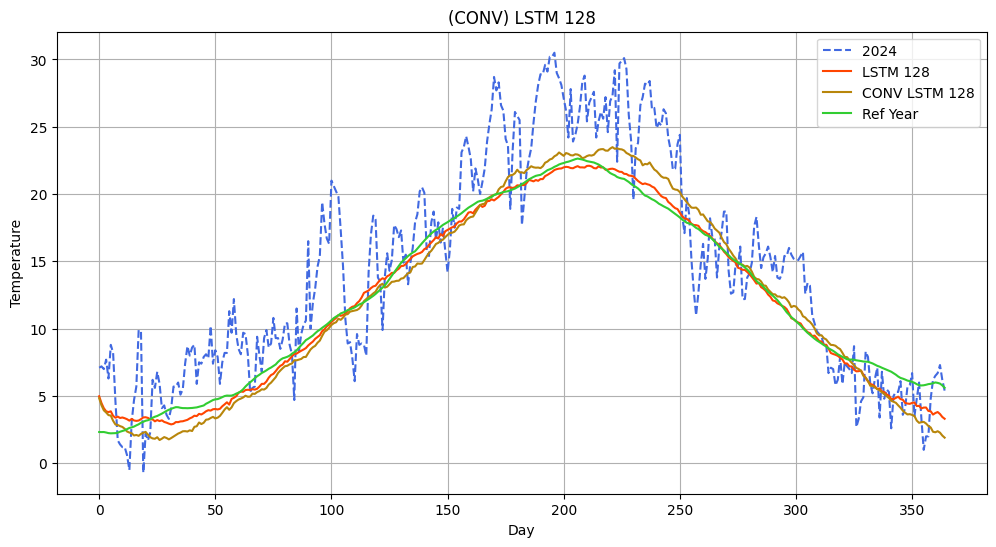

In [43]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128[:, 2], label="LSTM 128", color='orangered')
plt.plot(x, Y_conv_lstm_128[:, 2], label="CONV LSTM 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [44]:
lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_3232 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 196.2261 - mae: 11.4375 - val_loss: 129.7307 - val_mae: 8.8812
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 103.0817 - mae: 8.0491 - val_loss: 88.1375 - val_mae: 7.4957
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 75.4431 - mae: 7.0918 - val_loss: 74.3285 - val_mae: 7.1205
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 67.4321 - mae: 6.8366 - val_loss: 70.1816 - val_mae: 7.0256
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 65.3512 - mae: 6.7754 - val_loss: 69.0590 - val_mae: 7.0086
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 65.0656 - mae: 6.7731 - val_loss: 68.7624 - val_mae: 7.0062
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 64.9931 - mae: 6.7719 - val_loss: 68.6940 - val_mae: 7.0060
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 64.9819 - mae: 6.7723 - val_loss: 68.6746 - val_mae: 7.0060
Epoch 9/80
183/183 ━━━━━━━

In [45]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_2 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 16.6803 - mae: 3.2110 - val_loss: 17.7242 - val_mae: 3.3602
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 15.8274 - mae: 3.1258 - val_loss: 15.5937 - val_mae: 3.1541
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 14.6118 - mae: 2.9974 - val_loss: 15.2313 - val_mae: 3.1173
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 14.2731 - mae: 2.9597 - val_loss: 15.0291 - val_mae: 3.0969
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 13.9975 - mae: 2.9288 - val_loss: 14.6291 - val_mae: 3.0562
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 13.7587 - mae: 2.9019 - val_loss: 14.4128 - val_mae: 3.0333
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 13.6072 - mae: 2.8856 - val_loss: 14.1598 - val_mae: 3.0070
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 13.4518 - mae: 2.8687 - val_loss: 13.9162 - val_mae: 2.9815
Epoch 9/10
183/183 ━━━━━━━━━━

In [47]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_3 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 13.1708 - mae: 2.8364 - val_loss: 13.4714 - val_mae: 2.9327
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 13.0914 - mae: 2.8268 - val_loss: 13.4887 - val_mae: 2.9345
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 13.0148 - mae: 2.8185 - val_loss: 13.4759 - val_mae: 2.9363
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 12.9655 - mae: 2.8126 - val_loss: 13.1778 - val_mae: 2.8996
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 12.9302 - mae: 2.8088 - val_loss: 13.3434 - val_mae: 2.9197
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 12.8881 - mae: 2.8037 - val_loss: 13.4786 - val_mae: 2.9381
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 12.8629 - mae: 2.8009 - val_loss: 12.9991 - val_mae: 2.8791
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 12.8218 - mae: 2.7964 - val_loss: 12.7840 - val_mae: 2.8536
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_4 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 12.7345 - mae: 2.7868 - val_loss: 12.7146 - val_mae: 2.8438
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 12.6823 - mae: 2.7810 - val_loss: 12.7694 - val_mae: 2.8501
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 12.6626 - mae: 2.7789 - val_loss: 12.6008 - val_mae: 2.8301
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 12.5975 - mae: 2.7708 - val_loss: 12.6771 - val_mae: 2.8379
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 12.5588 - mae: 2.7666 - val_loss: 12.5222 - val_mae: 2.8200
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 12.5479 - mae: 2.7656 - val_loss: 12.5158 - val_mae: 2.8194
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 12.5319 - mae: 2.7637 - val_loss: 12.6318 - val_mae: 2.8334
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 12.5133 - mae: 2.7616 - val_loss: 12.5319 - val_mae: 2.8216
Epoch 9/10
183/183 ━━━━━━━

In [10]:
lstm_3232 = tf.keras.models.load_model('models/lstm_3232.keras')

Y_lstm_3232 = lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_3232 = Y_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_3232_pred.csv')

mae_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_3232:.3f}')

rmse_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Mean Absolute Error (MAE): 3.219
Root Mean Squared Error (RMSE): 3.928


In [49]:
conv_lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_3232 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 195.7729 - mae: 11.4210 - val_loss: 131.4030 - val_mae: 8.9406
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 104.4524 - mae: 8.0986 - val_loss: 89.1316 - val_mae: 7.5249
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 76.1834 - mae: 7.1186 - val_loss: 74.7401 - val_mae: 7.1303
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 67.6033 - mae: 6.8420 - val_loss: 70.3275 - val_mae: 7.0284
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.3725 - mae: 6.7748 - val_loss: 69.1053 - val_mae: 7.0091
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 64.9908 - mae: 6.7687 - val_loss: 68.7818 - val_mae: 7.0065
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 64.9347 - mae: 6.7681 - val_loss: 68.7002 - val_mae: 7.0060
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 64.9274 - mae: 6.7695 - val_loss: 68.6754 - val_mae: 7.0059
Epoch 9/60
183/183 ━━━━━━━━━

In [12]:
from tensorflow.keras.models import load_model
conv_lstm_3232 = load_model('models/conv_lstm_3232.keras')
history_conv_lstm_3232_2 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 12.0700 - mae: 2.7109 - val_loss: 12.3440 - val_mae: 2.7851
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.0282 - mae: 2.7059 - val_loss: 12.4132 - val_mae: 2.7917
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.0042 - mae: 2.7030 - val_loss: 12.3218 - val_mae: 2.7809
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.9819 - mae: 2.7004 - val_loss: 12.4468 - val_mae: 2.7935
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 11.9342 - mae: 2.6944 - val_loss: 12.2959 - val_mae: 2.7768
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.8996 - mae: 2.6900 - val_loss: 12.4622 - val_mae: 2.7949
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 11.8916 - mae: 2.6895 - val_loss: 12.3565 - val_mae: 2.7848
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 11.8405 - mae: 2.6834 - val_loss: 12.4008 - val_mae: 2.7888
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [13]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')

Y_conv_lstm_3232 = conv_lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_3232 = Y_conv_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_3232_pred.csv')

mae_conv_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_3232:.3f}')

rmse_conv_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Mean Absolute Error (MAE): 3.153
Root Mean Squared Error (RMSE): 3.839


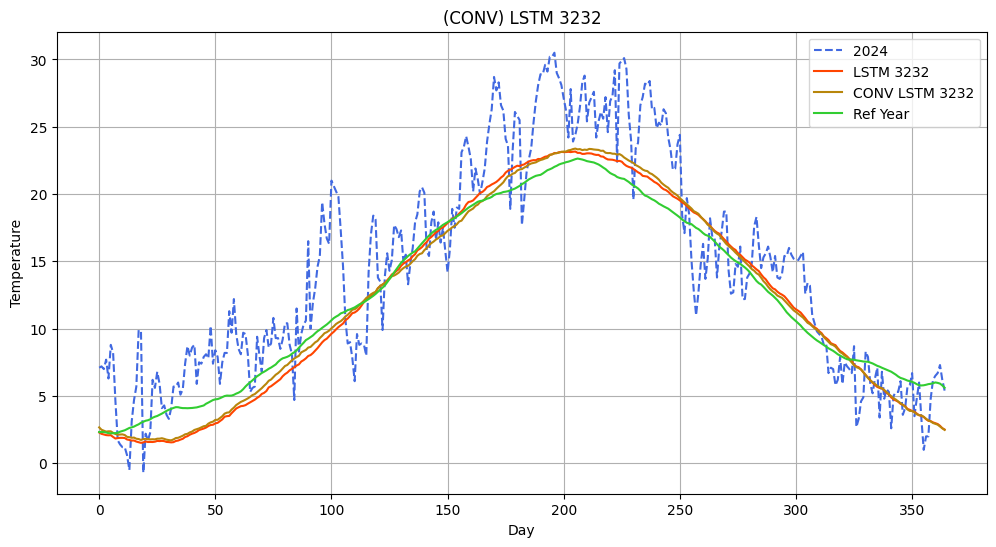

In [14]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_3232[:, 2], label="LSTM 3232", color='orangered')
plt.plot(x, Y_conv_lstm_3232[:, 2], label="CONV LSTM 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [17]:
lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_6464 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 173.2308 - mae: 10.6024 - val_loss: 88.2268 - val_mae: 7.4998
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 73.2789 - mae: 7.0241 - val_loss: 70.1992 - val_mae: 7.0263
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 65.3127 - mae: 6.7767 - val_loss: 68.7878 - val_mae: 7.0069
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 64.8910 - mae: 6.7670 - val_loss: 68.6960 - val_mae: 7.0071
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 64.9934 - mae: 6.7726 - val_loss: 68.6876 - val_mae: 7.0069
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 64.9277 - mae: 6.7693 - val_loss: 68.7046 - val_mae: 7.0069
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 65.0415 - mae: 6.7745 - val_loss: 68.7008 - val_mae: 7.0069
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 65.0011 - mae: 6.7725 - val_loss: 68.7072 - val_mae: 7.0074
Epoch 9/60
183/183 ━━━━━━━━

In [19]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_2 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 12.3119 - mae: 2.7393 - val_loss: 13.2083 - val_mae: 2.8980
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 12.2727 - mae: 2.7349 - val_loss: 12.8122 - val_mae: 2.8505
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 12.1272 - mae: 2.7177 - val_loss: 12.6245 - val_mae: 2.8274
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 12.0940 - mae: 2.7132 - val_loss: 12.7639 - val_mae: 2.8456
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 12.0779 - mae: 2.7115 - val_loss: 12.9479 - val_mae: 2.8653
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 12.0533 - mae: 2.7082 - val_loss: 12.8056 - val_mae: 2.8482
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 12.0377 - mae: 2.7062 - val_loss: 12.7532 - val_mae: 2.8418
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 12.0233 - mae: 2.7050 - val_loss: 12.7886 - val_mae: 2.8451
Epoch 9/10
183/183 ━━━━━━━━━

In [20]:
lstm_6464 = tf.keras.models.load_model('models/lstm_6464.keras')

Y_lstm_6464 = lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_6464 = Y_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_6464_pred.csv')

mae_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_6464:.3f}')

rmse_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Mean Absolute Error (MAE): 2.867
Root Mean Squared Error (RMSE): 3.514


In [54]:
conv_lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_6464 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 172.6380 - mae: 10.5807 - val_loss: 88.8125 - val_mae: 7.5170
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 73.6866 - mae: 7.0377 - val_loss: 70.2920 - val_mae: 7.0280
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.3318 - mae: 6.7767 - val_loss: 68.8152 - val_mae: 7.0076
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 64.9394 - mae: 6.7686 - val_loss: 68.6790 - val_mae: 7.0059
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 64.9803 - mae: 6.7713 - val_loss: 68.6893 - val_mae: 7.0068
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 64.9309 - mae: 6.7691 - val_loss: 68.7123 - val_mae: 7.0077
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.0321 - mae: 6.7743 - val_loss: 68.7082 - val_mae: 7.0072
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 64.9946 - mae: 6.7733 - val_loss: 68.6989 - val_mae: 7.0064
Epoch 9/50
183/183 ━━━━━━━━━━━

In [55]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_2 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 14.4894 - mae: 2.9824 - val_loss: 14.4976 - val_mae: 3.0458
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.7332 - mae: 2.9013 - val_loss: 14.1449 - val_mae: 3.0106
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.2328 - mae: 2.8444 - val_loss: 13.3422 - val_mae: 2.9203
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.9947 - mae: 2.8176 - val_loss: 13.1904 - val_mae: 2.9028
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.8272 - mae: 2.7980 - val_loss: 13.2777 - val_mae: 2.9130
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.7129 - mae: 2.7844 - val_loss: 13.3403 - val_mae: 2.9219
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 12.6628 - mae: 2.7786 - val_loss: 12.9571 - val_mae: 2.8765
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.6407 - mae: 2.7764 - val_loss: 12.7806 - val_mae: 2.8531
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [21]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_3 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 12.4134 - mae: 2.7506 - val_loss: 12.7221 - val_mae: 2.8474
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.3369 - mae: 2.7417 - val_loss: 12.6956 - val_mae: 2.8422
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 12.2846 - mae: 2.7363 - val_loss: 12.7341 - val_mae: 2.8460
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.2976 - mae: 2.7379 - val_loss: 12.9163 - val_mae: 2.8644
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.2543 - mae: 2.7341 - val_loss: 12.9642 - val_mae: 2.8690
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.1665 - mae: 2.7238 - val_loss: 13.3104 - val_mae: 2.9068
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.1355 - mae: 2.7202 - val_loss: 12.9241 - val_mae: 2.8668
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.1442 - mae: 2.7215 - val_loss: 13.1569 - val_mae: 2.8868
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [23]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_4 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 11.9603 - mae: 2.6997 - val_loss: 13.0790 - val_mae: 2.8814
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.9293 - mae: 2.6967 - val_loss: 12.8952 - val_mae: 2.8587
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.8907 - mae: 2.6915 - val_loss: 13.1721 - val_mae: 2.8942
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.8380 - mae: 2.6855 - val_loss: 12.8699 - val_mae: 2.8545
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.8032 - mae: 2.6813 - val_loss: 13.1155 - val_mae: 2.8828
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.7764 - mae: 2.6778 - val_loss: 12.8969 - val_mae: 2.8605
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.7646 - mae: 2.6767 - val_loss: 13.2442 - val_mae: 2.8988
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.7428 - mae: 2.6740 - val_loss: 12.8875 - val_mae: 2.8570
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [24]:
conv_lstm_6464 = tf.keras.models.load_model('models/conv_lstm_6464.keras')

Y_conv_lstm_6464 = conv_lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_6464 = Y_conv_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_6464_pred.csv')

mae_conv_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_6464:.3f}')

rmse_conv_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Mean Absolute Error (MAE): 2.985
Root Mean Squared Error (RMSE): 3.671


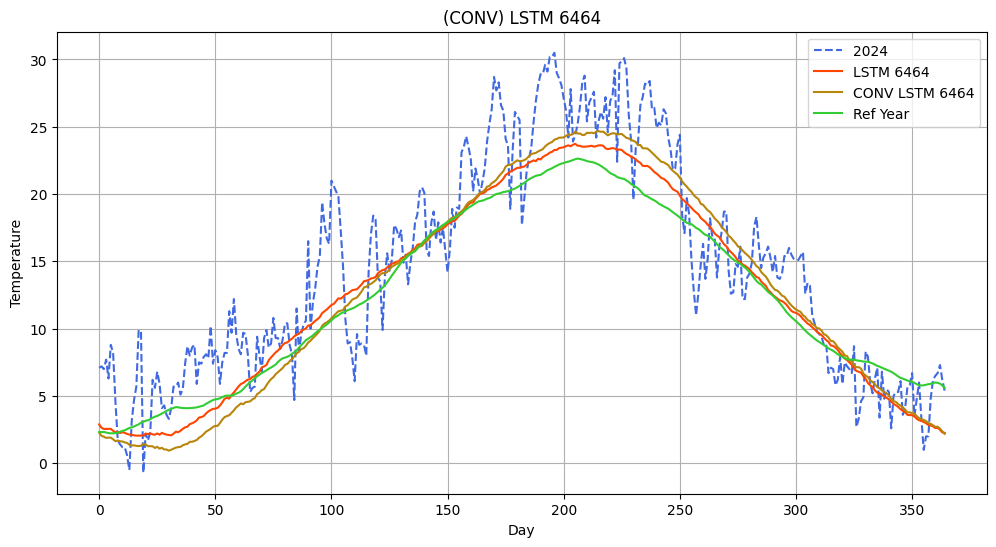

In [25]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_6464[:, 2], label="LSTM 6464", color='orangered')
plt.plot(x, Y_conv_lstm_6464[:, 2], label="CONV LSTM 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128128 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 145.5588 - mae: 9.5959 - val_loss: 67.1706 - val_mae: 6.8664
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 61.8731 - mae: 6.5849 - val_loss: 63.3655 - val_mae: 6.7020
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 59.3727 - mae: 6.4473 - val_loss: 61.1210 - val_mae: 6.5695
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 57.2218 - mae: 6.3180 - val_loss: 59.2757 - val_mae: 6.4550
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 55.3406 - mae: 6.2046 - val_loss: 56.9915 - val_mae: 6.3223
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 53.4430 - mae: 6.0876 - val_loss: 54.9479 - val_mae: 6.1925
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 51.3343 - mae: 5.9536 - val_loss: 52.6842 - val_mae: 6.0510
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 49.0825 - mae: 5.8091 - val_loss: 50.5469 - val_mae: 5.9081
Epoch 9/50
183/183 ━━━━━━━━━━

In [26]:
from tensorflow.keras.models import load_model
lstm_128128 = load_model('models/lstm_128128.keras')
history_lstm_128128_2 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 11.8868 - mae: 2.6907 - val_loss: 12.8228 - val_mae: 2.8479
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 11.8874 - mae: 2.6908 - val_loss: 12.6884 - val_mae: 2.8324
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 11.8881 - mae: 2.6910 - val_loss: 12.7671 - val_mae: 2.8400
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.9054 - mae: 2.6940 - val_loss: 12.7702 - val_mae: 2.8417
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 11.7732 - mae: 2.6775 - val_loss: 12.7930 - val_mae: 2.8428
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 11.8041 - mae: 2.6814 - val_loss: 12.6496 - val_mae: 2.8252
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 11.7725 - mae: 2.6778 - val_loss: 12.6919 - val_mae: 2.8301
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 11.7135 - mae: 2.6709 - val_loss: 12.6822 - val_mae: 2.8309
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [27]:
lstm_128128 = tf.keras.models.load_model('models/lstm_128128.keras')

Y_lstm_128128 = lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128128 = Y_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128128_pred.csv')

mae_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128128:.3f}')

rmse_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Mean Absolute Error (MAE): 3.213
Root Mean Squared Error (RMSE): 3.866


In [9]:
conv_lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128128 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 144.8697 - mae: 9.5788 - val_loss: 69.9301 - val_mae: 7.0224
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 65.1387 - mae: 6.7723 - val_loss: 68.6998 - val_mae: 7.0067
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 65.0354 - mae: 6.7743 - val_loss: 68.7912 - val_mae: 7.0113
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.0432 - mae: 6.7752 - val_loss: 68.7929 - val_mae: 7.0108
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.0442 - mae: 6.7748 - val_loss: 68.7894 - val_mae: 7.0103
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 65.1238 - mae: 6.7796 - val_loss: 68.7553 - val_mae: 7.0088
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.0338 - mae: 6.7747 - val_loss: 68.7698 - val_mae: 7.0086
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 64.9887 - mae: 6.7719 - val_loss: 68.7836 - val_mae: 7.0095
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [11]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_2 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 12.9426 - mae: 2.8122 - val_loss: 14.2960 - val_mae: 3.0174
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.9095 - mae: 2.8085 - val_loss: 13.6317 - val_mae: 2.9472
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.9483 - mae: 2.8125 - val_loss: 13.7884 - val_mae: 2.9661
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.7107 - mae: 2.7851 - val_loss: 13.3402 - val_mae: 2.9150
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.6400 - mae: 2.7763 - val_loss: 13.3891 - val_mae: 2.9203
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.5562 - mae: 2.7666 - val_loss: 13.0793 - val_mae: 2.8838
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.4923 - mae: 2.7591 - val_loss: 13.4483 - val_mae: 2.9226
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.3993 - mae: 2.7495 - val_loss: 13.6132 - val_mae: 2.9337
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [13]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_3 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 12.2724 - mae: 2.7358 - val_loss: 14.4592 - val_mae: 3.0226
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.1798 - mae: 2.7245 - val_loss: 14.1766 - val_mae: 2.9945
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.1467 - mae: 2.7201 - val_loss: 14.4124 - val_mae: 3.0206
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 12.1288 - mae: 2.7179 - val_loss: 14.8863 - val_mae: 3.0714
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.1012 - mae: 2.7148 - val_loss: 14.5756 - val_mae: 3.0407
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.1397 - mae: 2.7189 - val_loss: 14.8187 - val_mae: 3.0669
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.0963 - mae: 2.7141 - val_loss: 14.8509 - val_mae: 3.0714
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 12.0489 - mae: 2.7084 - val_loss: 14.8899 - val_mae: 3.0747
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [28]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_4 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 11.9945 - mae: 2.7014 - val_loss: 15.1759 - val_mae: 3.1053
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.9971 - mae: 2.7019 - val_loss: 14.7246 - val_mae: 3.0583
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.9518 - mae: 2.6963 - val_loss: 14.8253 - val_mae: 3.0727
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.9489 - mae: 2.6957 - val_loss: 14.9002 - val_mae: 3.0811
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.9427 - mae: 2.6955 - val_loss: 14.9271 - val_mae: 3.0851
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.8966 - mae: 2.6898 - val_loss: 14.5460 - val_mae: 3.0434
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.9210 - mae: 2.6928 - val_loss: 14.7616 - val_mae: 3.0654
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.8854 - mae: 2.6882 - val_loss: 15.1613 - val_mae: 3.1107
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [29]:
conv_lstm_128128 = tf.keras.models.load_model('models/conv_lstm_128128.keras')

Y_conv_lstm_128128 = conv_lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128128 = Y_conv_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128128_pred.csv')

mae_conv_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128128:.3f}')

rmse_conv_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Mean Absolute Error (MAE): 3.008
Root Mean Squared Error (RMSE): 3.670


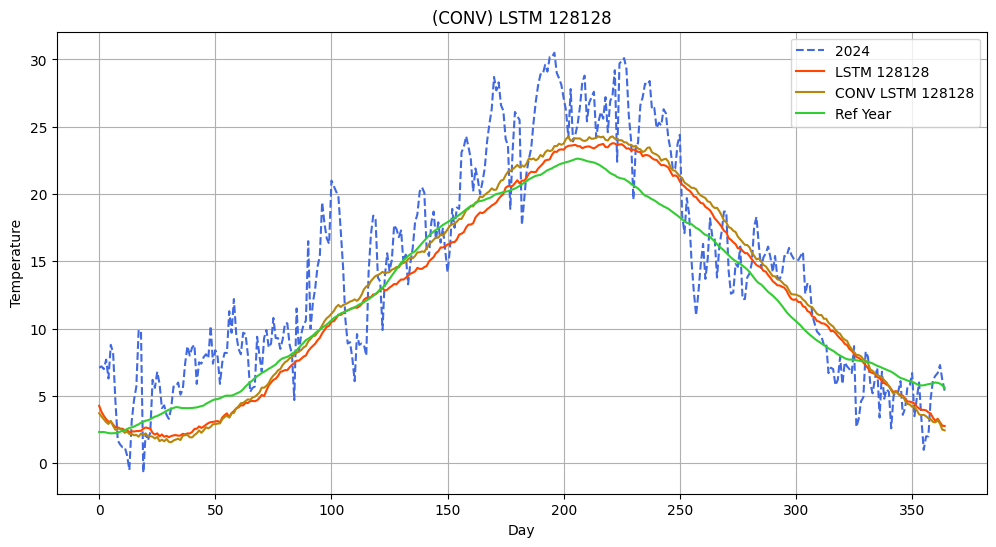

In [30]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128128[:, 2], label="LSTM 128128", color='orangered')
plt.plot(x, Y_conv_lstm_128128[:, 2], label="CONV LSTM 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [11]:
gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_32 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=70)
gru_32.save('models/gru_32.keras')

Epoch 1/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 196.4872 - mae: 11.4510 - val_loss: 138.3511 - val_mae: 9.1875
Epoch 2/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 109.9568 - mae: 8.2993 - val_loss: 93.1065 - val_mae: 7.6449
Epoch 3/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 78.8394 - mae: 7.2040 - val_loss: 76.4612 - val_mae: 7.1725
Epoch 4/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 68.5584 - mae: 6.8711 - val_loss: 70.9539 - val_mae: 7.0413
Epoch 5/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.7513 - mae: 6.7879 - val_loss: 69.3106 - val_mae: 7.0111
Epoch 6/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.0280 - mae: 6.7680 - val_loss: 68.8483 - val_mae: 7.0070
Epoch 7/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 64.9735 - mae: 6.7700 - val_loss: 68.7136 - val_mae: 7.0059
Epoch 8/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 64.9800 - mae: 6.7721 - val_loss: 68.6760 - val_mae: 7.0057
Epoch 9/70
183/183 ━━━━━━━━━

In [12]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_32_pred.csv')

mae_gru_32 = mean_absolute_error(Y_test[:, 2], Y_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_32:.3f}')

rmse_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Mean Absolute Error (MAE): 3.120
Root Mean Squared Error (RMSE): 3.815


In [22]:
conv_gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_32 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 195.7552 - mae: 11.4244 - val_loss: 139.1302 - val_mae: 9.2153
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 110.5341 - mae: 8.3206 - val_loss: 93.7378 - val_mae: 7.6647
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 79.2435 - mae: 7.2182 - val_loss: 76.7749 - val_mae: 7.1804
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 68.8174 - mae: 6.8794 - val_loss: 71.0733 - val_mae: 7.0438
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.7815 - mae: 6.7872 - val_loss: 69.3505 - val_mae: 7.0113
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 65.1210 - mae: 6.7723 - val_loss: 68.8574 - val_mae: 7.0070
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.9439 - mae: 6.7680 - val_loss: 68.7201 - val_mae: 7.0060
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 64.9861 - mae: 6.7715 - val_loss: 68.6862 - val_mae: 7.0060
Epoch 9/60
183/183 ━━━━━━━━━━

In [37]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_2 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 12.0647 - mae: 2.7123 - val_loss: 14.0075 - val_mae: 2.9805
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.0127 - mae: 2.7066 - val_loss: 13.9356 - val_mae: 2.9755
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.9941 - mae: 2.7041 - val_loss: 14.0740 - val_mae: 2.9884
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.9921 - mae: 2.7040 - val_loss: 14.0271 - val_mae: 2.9796
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.9626 - mae: 2.7004 - val_loss: 13.8122 - val_mae: 2.9583
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.9537 - mae: 2.6993 - val_loss: 13.9757 - val_mae: 2.9761
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.9353 - mae: 2.6970 - val_loss: 14.1973 - val_mae: 2.9956
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.9289 - mae: 2.6959 - val_loss: 14.1250 - val_mae: 2.9893
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [38]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')

Y_conv_gru_32 = conv_gru_32.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_32 = Y_conv_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_32_pred.csv')

mae_conv_gru_32 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_32:.3f}')

rmse_conv_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Mean Absolute Error (MAE): 2.950
Root Mean Squared Error (RMSE): 3.603


In [13]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')

Y_conv_gru_32 = conv_gru_32.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_32 = Y_conv_gru_32[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


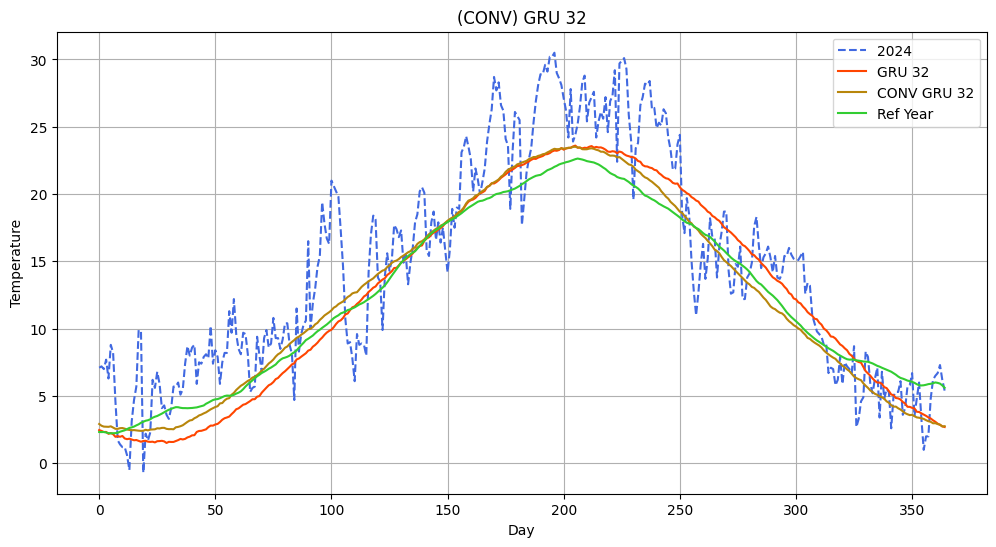

In [14]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_32[:, 2], label="GRU 32", color='orangered')
plt.plot(x, Y_conv_gru_32[:, 2], label="CONV GRU 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [25]:
gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_64 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_64.save('models/gru_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 173.4425 - mae: 10.6110 - val_loss: 92.2339 - val_mae: 7.6194
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 75.5124 - mae: 7.0959 - val_loss: 70.8623 - val_mae: 7.0398
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 65.5836 - mae: 6.7849 - val_loss: 68.8713 - val_mae: 7.0078
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 64.9605 - mae: 6.7696 - val_loss: 68.6952 - val_mae: 7.0063
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 64.9430 - mae: 6.7695 - val_loss: 68.6862 - val_mae: 7.0062
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 65.0104 - mae: 6.7735 - val_loss: 68.6750 - val_mae: 7.0060
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 64.9303 - mae: 6.7696 - val_loss: 68.6815 - val_mae: 7.0064
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 65.0480 - mae: 6.7756 - val_loss: 68.6893 - val_mae: 7.0066
Epoch 9/60
183/183 ━━━━━━━━━━━

In [26]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')

Y_gru_64 = gru_64.predict(X)  # shape: (1, 365, 3)
Y_gru_64 = Y_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_64_pred.csv')

mae_gru_64 = mean_absolute_error(Y_test[:, 2], Y_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_64:.3f}')

rmse_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Mean Absolute Error (MAE): 3.221
Root Mean Squared Error (RMSE): 3.929


In [27]:
conv_gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_64 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 173.3571 - mae: 10.6107 - val_loss: 92.7819 - val_mae: 7.6365
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 75.7781 - mae: 7.1049 - val_loss: 70.9687 - val_mae: 7.0422
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.5739 - mae: 6.7834 - val_loss: 68.8799 - val_mae: 7.0076
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 64.9543 - mae: 6.7690 - val_loss: 68.6927 - val_mae: 7.0062
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 64.9874 - mae: 6.7718 - val_loss: 68.6799 - val_mae: 7.0063
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0023 - mae: 6.7736 - val_loss: 68.6848 - val_mae: 7.0065
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.0116 - mae: 6.7734 - val_loss: 68.6729 - val_mae: 7.0061
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 65.0026 - mae: 6.7729 - val_loss: 68.7139 - val_mae: 7.0071
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [28]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')

Y_conv_gru_64 = conv_gru_64.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_64 = Y_conv_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_64_pred.csv')

mae_conv_gru_64 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_64:.3f}')

rmse_conv_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Mean Absolute Error (MAE): 2.977
Root Mean Squared Error (RMSE): 3.627


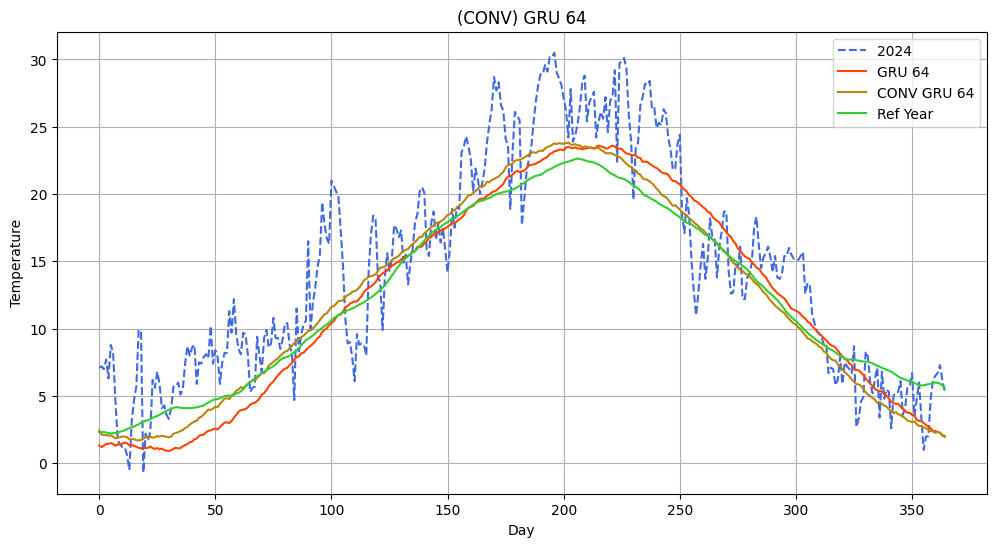

In [29]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_64[:, 2], label="GRU 64", color='orangered')
plt.plot(x, Y_conv_gru_64[:, 2], label="CONV GRU 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [42]:
gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
gru_128.save('models/gru_128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 144.8183 - mae: 9.5796 - val_loss: 70.2367 - val_mae: 7.0286
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 65.1416 - mae: 6.7700 - val_loss: 67.5542 - val_mae: 6.9388
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 63.4916 - mae: 6.6845 - val_loss: 65.9701 - val_mae: 6.8498
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 62.0624 - mae: 6.6004 - val_loss: 64.5469 - val_mae: 6.7679
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 60.7032 - mae: 6.5208 - val_loss: 63.1399 - val_mae: 6.6873
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 59.0873 - mae: 6.4249 - val_loss: 59.7958 - val_mae: 6.4851
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 55.5989 - mae: 6.2109 - val_loss: 56.0396 - val_mae: 6.2547
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 52.2577 - mae: 6.0007 - val_loss: 53.3317 - val_mae: 6.0814
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [44]:
from tensorflow.keras.models import load_model
gru_128 = load_model('models/gru_128.keras')
history_gru_128_2 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128.save('models/gru_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 11.8154 - mae: 2.6824 - val_loss: 13.2257 - val_mae: 2.8964
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.7762 - mae: 2.6790 - val_loss: 13.2484 - val_mae: 2.8966
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.6881 - mae: 2.6681 - val_loss: 13.6786 - val_mae: 2.9470
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.6572 - mae: 2.6650 - val_loss: 13.3178 - val_mae: 2.9039
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.6142 - mae: 2.6602 - val_loss: 13.4795 - val_mae: 2.9230
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.5451 - mae: 2.6521 - val_loss: 13.5600 - val_mae: 2.9337
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.4962 - mae: 2.6458 - val_loss: 13.7587 - val_mae: 2.9545
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.4941 - mae: 2.6461 - val_loss: 13.6775 - val_mae: 2.9439
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [45]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')

Y_gru_128 = gru_128.predict(X)  # shape: (1, 365, 3)
Y_gru_128 = Y_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128_pred.csv')

mae_gru_128 = mean_absolute_error(Y_test[:, 2], Y_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128:.3f}')

rmse_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Mean Absolute Error (MAE): 3.259
Root Mean Squared Error (RMSE): 3.937


In [48]:
conv_gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 145.1909 - mae: 9.5911 - val_loss: 70.4466 - val_mae: 7.0322
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.2808 - mae: 6.7766 - val_loss: 68.7816 - val_mae: 7.0104
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0250 - mae: 6.7745 - val_loss: 68.7041 - val_mae: 7.0080
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0038 - mae: 6.7731 - val_loss: 68.7844 - val_mae: 7.0105
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 65.0131 - mae: 6.7737 - val_loss: 68.7621 - val_mae: 7.0023
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.3017 - mae: 6.7310 - val_loss: 66.2591 - val_mae: 6.8646
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 62.2178 - mae: 6.6089 - val_loss: 64.1345 - val_mae: 6.7383
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 59.3282 - mae: 6.4371 - val_loss: 58.2814 - val_mae: 6.3912
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [49]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')

Y_conv_gru_128 = conv_gru_128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128 = Y_conv_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128_pred.csv')

mae_conv_gru_128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128:.3f}')

rmse_conv_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Mean Absolute Error (MAE): 3.072
Root Mean Squared Error (RMSE): 3.743


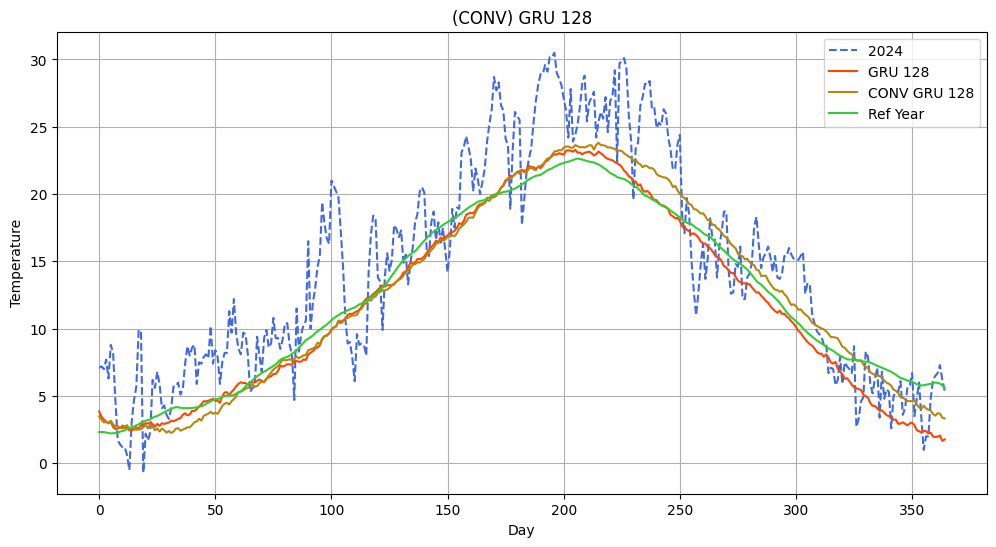

In [50]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128[:, 2], label="GRU 128", color='orangered')
plt.plot(x, Y_conv_gru_128[:, 2], label="CONV GRU 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [9]:
gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_3232 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_3232.save('models/gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 194.8919 - mae: 11.3953 - val_loss: 135.9506 - val_mae: 9.1028
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 108.0769 - mae: 8.2316 - val_loss: 91.8788 - val_mae: 7.6074
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 78.0766 - mae: 7.1803 - val_loss: 75.9356 - val_mae: 7.1594
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 68.2683 - mae: 6.8615 - val_loss: 70.7591 - val_mae: 7.0370
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 65.5768 - mae: 6.7810 - val_loss: 69.2462 - val_mae: 7.0104
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 65.0261 - mae: 6.7689 - val_loss: 68.8291 - val_mae: 7.0068
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 64.9018 - mae: 6.7668 - val_loss: 68.7110 - val_mae: 7.0060
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 64.9417 - mae: 6.7694 - val_loss: 68.6745 - val_mae: 7.0056
Epoch 9/60
183/183 ━━━━━

In [10]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')

Y_gru_3232 = gru_3232.predict(X)  # shape: (1, 365, 3)
Y_gru_3232 = Y_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_3232_pred.csv')

mae_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_3232:.3f}')

rmse_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Mean Absolute Error (MAE): 3.210
Root Mean Squared Error (RMSE): 3.920


In [11]:
conv_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_3232 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 195.3349 - mae: 11.4083 - val_loss: 136.4212 - val_mae: 9.1191
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 108.4600 - mae: 8.2445 - val_loss: 92.1206 - val_mae: 7.6150
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 78.2132 - mae: 7.1850 - val_loss: 76.0442 - val_mae: 7.1623
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 68.3666 - mae: 6.8652 - val_loss: 70.7943 - val_mae: 7.0378
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.6284 - mae: 6.7832 - val_loss: 69.2572 - val_mae: 7.0105
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 65.0399 - mae: 6.7693 - val_loss: 68.8274 - val_mae: 7.0069
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 64.9711 - mae: 6.7696 - val_loss: 68.7143 - val_mae: 7.0063
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 64.9832 - mae: 6.7720 - val_loss: 68.6833 - val_mae: 7.0060
Epoch 9/50
183/183 ━━━━━━━━━

In [12]:
conv_gru_3232 = tf.keras.models.load_model('models/conv_gru_3232.keras')

Y_conv_gru_3232 = conv_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_3232 = Y_conv_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_3232_pred.csv')

mae_conv_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_3232:.3f}')

rmse_conv_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Mean Absolute Error (MAE): 2.770
Root Mean Squared Error (RMSE): 3.404


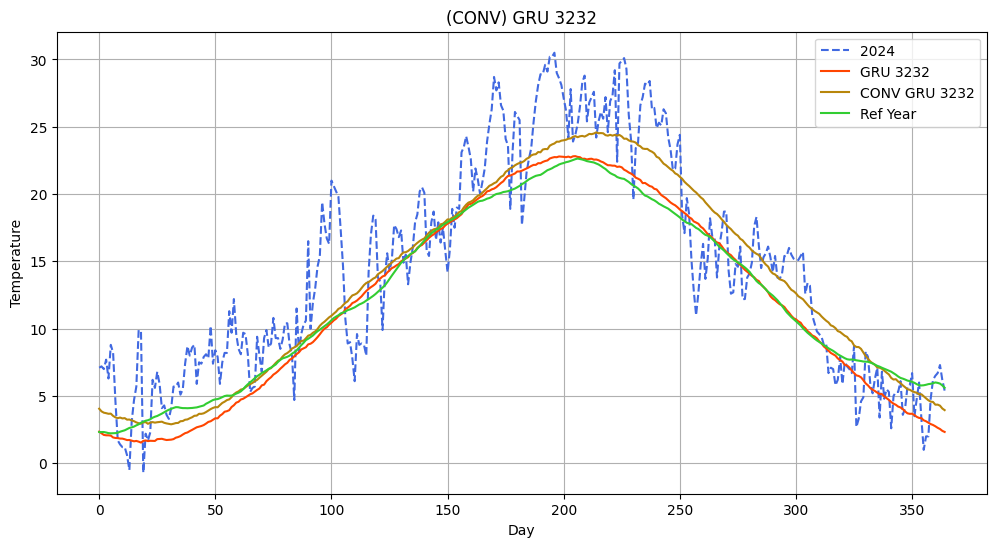

In [13]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_3232[:, 2], label="GRU 3232", color='orangered')
plt.plot(x, Y_conv_gru_3232[:, 2], label="CONV GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [14]:
gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_6464 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
gru_6464.save('models/gru_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 172.6026 - mae: 10.5826 - val_loss: 91.4467 - val_mae: 7.5956
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 75.1294 - mae: 7.0842 - val_loss: 70.7273 - val_mae: 7.0368
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 65.4582 - mae: 6.7787 - val_loss: 68.8539 - val_mae: 7.0079
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 65.0298 - mae: 6.7737 - val_loss: 68.6949 - val_mae: 7.0063
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 65.0274 - mae: 6.7742 - val_loss: 68.6843 - val_mae: 7.0067
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 64.9992 - mae: 6.7733 - val_loss: 68.6783 - val_mae: 7.0060
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 64.9422 - mae: 6.7697 - val_loss: 68.7188 - val_mae: 7.0081
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 64.9937 - mae: 6.7729 - val_loss: 68.6983 - val_mae: 7.0066
Epoch 9/50
183/183 ━━━━━━━━━━

In [51]:
from tensorflow.keras.models import load_model
gru_6464 = load_model('models/gru_6464.keras')
history_gru_6464_2 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_6464.save('models/gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 11.8691 - mae: 2.6885 - val_loss: 13.9914 - val_mae: 2.9955
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 11.8295 - mae: 2.6840 - val_loss: 14.1848 - val_mae: 3.0129
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 11.7802 - mae: 2.6781 - val_loss: 14.1084 - val_mae: 3.0078
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 11.7518 - mae: 2.6749 - val_loss: 14.3205 - val_mae: 3.0272
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 11.7148 - mae: 2.6705 - val_loss: 13.9738 - val_mae: 2.9883
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 11.6770 - mae: 2.6661 - val_loss: 14.0723 - val_mae: 2.9997
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 11.6540 - mae: 2.6639 - val_loss: 14.0398 - val_mae: 2.9943
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 11.6256 - mae: 2.6601 - val_loss: 14.1676 - val_mae: 3.0086
Epoch 9/10
183/183 ━━━━━━━━━━━

In [52]:
gru_6464 = tf.keras.models.load_model('models/gru_6464.keras')

Y_gru_6464 = gru_6464.predict(X)  # shape: (1, 365, 3)
Y_gru_6464 = Y_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_6464_pred.csv')

mae_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_6464:.3f}')

rmse_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Mean Absolute Error (MAE): 3.349
Root Mean Squared Error (RMSE): 4.036


In [16]:
conv_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_6464 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 172.9993 - mae: 10.5963 - val_loss: 91.7334 - val_mae: 7.6047
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 75.2763 - mae: 7.0891 - val_loss: 70.7808 - val_mae: 7.0380
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 65.5189 - mae: 6.7819 - val_loss: 68.8469 - val_mae: 7.0071
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 65.0000 - mae: 6.7721 - val_loss: 68.6843 - val_mae: 7.0059
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 64.9642 - mae: 6.7709 - val_loss: 68.6939 - val_mae: 7.0071
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 65.0288 - mae: 6.7746 - val_loss: 68.6883 - val_mae: 7.0067
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 64.9741 - mae: 6.7722 - val_loss: 68.6687 - val_mae: 7.0061
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 64.9869 - mae: 6.7729 - val_loss: 68.7025 - val_mae: 7.0074
Epoch 9/40
183/183 ━━━━━━━━━━━

In [53]:
from tensorflow.keras.models import load_model
conv_gru_6464 = load_model('models/conv_gru_6464.keras')
history_conv_gru_6464_2 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 11.6128 - mae: 2.6588 - val_loss: 13.2618 - val_mae: 2.9003
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.5587 - mae: 2.6520 - val_loss: 13.4916 - val_mae: 2.9267
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.5372 - mae: 2.6494 - val_loss: 13.4803 - val_mae: 2.9234
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.5048 - mae: 2.6458 - val_loss: 13.4232 - val_mae: 2.9182
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.4607 - mae: 2.6405 - val_loss: 13.3276 - val_mae: 2.9084
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 11.4438 - mae: 2.6379 - val_loss: 13.4276 - val_mae: 2.9166
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.4377 - mae: 2.6374 - val_loss: 13.3483 - val_mae: 2.9076
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.4065 - mae: 2.6336 - val_loss: 13.4143 - val_mae: 2.9166
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [54]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')

Y_conv_gru_6464 = conv_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_6464 = Y_conv_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_6464_pred.csv')

mae_conv_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_6464:.3f}')

rmse_conv_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Mean Absolute Error (MAE): 3.062
Root Mean Squared Error (RMSE): 3.691


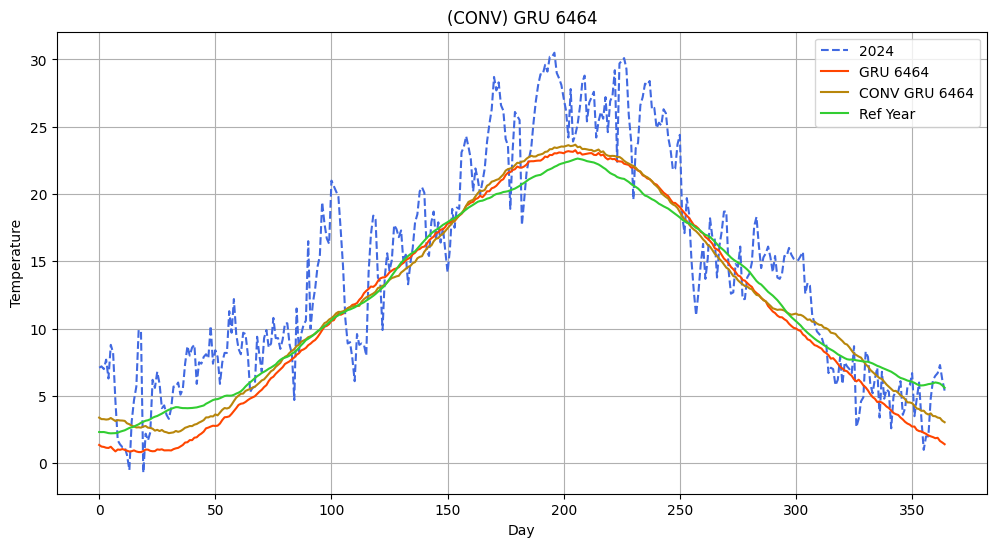

In [55]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_6464[:, 2], label="GRU 6464", color='orangered')
plt.plot(x, Y_conv_gru_6464[:, 2], label="CONV GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [19]:
gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128128 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_128128.save('models/gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 144.6382 - mae: 9.5715 - val_loss: 70.2775 - val_mae: 7.0291
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 65.2365 - mae: 6.7753 - val_loss: 68.7275 - val_mae: 7.0078
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 64.9975 - mae: 6.7723 - val_loss: 68.7697 - val_mae: 7.0101
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 65.0945 - mae: 6.7774 - val_loss: 68.7780 - val_mae: 7.0112
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 65.0574 - mae: 6.7751 - val_loss: 68.7789 - val_mae: 7.0094
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 65.0779 - mae: 6.7760 - val_loss: 68.7634 - val_mae: 7.0101
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 65.0076 - mae: 6.7723 - val_loss: 68.8107 - val_mae: 7.0105
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 65.0913 - mae: 6.7767 - val_loss: 68.8580 - val_mae: 7.0119
Epoch 9/40
183/183 ━━━━━━━━━━━

In [20]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')

Y_gru_128128 = gru_128128.predict(X)  # shape: (1, 365, 3)
Y_gru_128128 = Y_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128128_pred.csv')

mae_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128128:.3f}')

rmse_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Mean Absolute Error (MAE): 3.014
Root Mean Squared Error (RMSE): 3.645


In [21]:
conv_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128128 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 145.3844 - mae: 9.5987 - val_loss: 70.3425 - val_mae: 7.0303
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 65.1664 - mae: 6.7711 - val_loss: 68.7389 - val_mae: 7.0083
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 65.0213 - mae: 6.7740 - val_loss: 68.7624 - val_mae: 7.0094
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 64.9802 - mae: 6.7713 - val_loss: 68.7540 - val_mae: 7.0089
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 65.0351 - mae: 6.7754 - val_loss: 68.7182 - val_mae: 7.0078
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.0439 - mae: 6.7746 - val_loss: 68.7515 - val_mae: 7.0092
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.0000 - mae: 6.7726 - val_loss: 68.7772 - val_mae: 7.0097
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.0704 - mae: 6.7755 - val_loss: 68.7840 - val_mae: 7.0111
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [22]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')

Y_conv_gru_128128 = conv_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128128 = Y_conv_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128128_pred.csv')

mae_conv_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128128:.3f}')

rmse_conv_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Mean Absolute Error (MAE): 2.673
Root Mean Squared Error (RMSE): 3.263


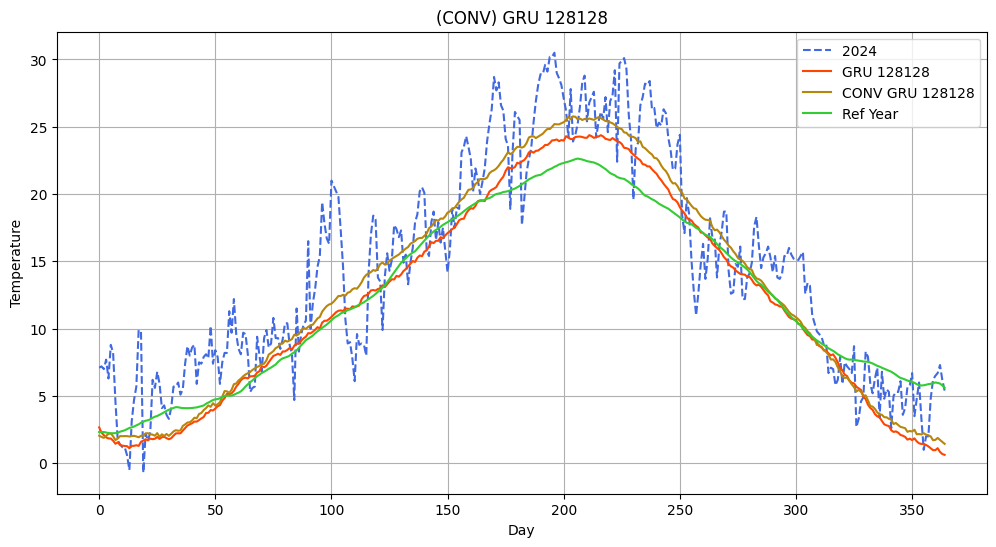

In [23]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128128[:, 2], label="GRU 128128", color='orangered')
plt.plot(x, Y_conv_gru_128128[:, 2], label="CONV GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [24]:
lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_3232 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 194.8414 - mae: 11.3885 - val_loss: 132.4441 - val_mae: 8.9775
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 105.2682 - mae: 8.1286 - val_loss: 89.9315 - val_mae: 7.5489
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 76.7308 - mae: 7.1357 - val_loss: 75.1112 - val_mae: 7.1394
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 67.7977 - mae: 6.8469 - val_loss: 70.4636 - val_mae: 7.0311
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 65.5163 - mae: 6.7815 - val_loss: 69.1484 - val_mae: 7.0095
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 65.0252 - mae: 6.7694 - val_loss: 68.7942 - val_mae: 7.0064
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 64.9905 - mae: 6.7715 - val_loss: 68.7026 - val_mae: 7.0060
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 64.9074 - mae: 6.7687 - val_loss: 68.6720 - val_mae: 7.0056
Epoch 9/80
183/183 ━━━━━━━━

In [25]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_3232_pred.csv')

mae_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_3232:.3f}')

rmse_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Mean Absolute Error (MAE): 3.012
Root Mean Squared Error (RMSE): 3.686


In [30]:
conv_lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_3232 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 194.9977 - mae: 11.3956 - val_loss: 133.6940 - val_mae: 9.0222
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 106.2587 - mae: 8.1654 - val_loss: 90.6324 - val_mae: 7.5698
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 77.1908 - mae: 7.1503 - val_loss: 75.4098 - val_mae: 7.1467
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 67.9517 - mae: 6.8513 - val_loss: 70.5687 - val_mae: 7.0333
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 65.5318 - mae: 6.7803 - val_loss: 69.1859 - val_mae: 7.0098
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.0897 - mae: 6.7730 - val_loss: 68.8110 - val_mae: 7.0067
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 64.9876 - mae: 6.7712 - val_loss: 68.7053 - val_mae: 7.0060
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 64.9261 - mae: 6.7691 - val_loss: 68.6766 - val_mae: 7.0058
Epoch 9/60
183/183 ━━━━━━━━━

In [31]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_2 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 13.3678 - mae: 2.8609 - val_loss: 14.7070 - val_mae: 3.0556
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 13.0547 - mae: 2.8259 - val_loss: 14.6842 - val_mae: 3.0542
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 12.8719 - mae: 2.8051 - val_loss: 14.6618 - val_mae: 3.0537
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 12.7196 - mae: 2.7874 - val_loss: 14.5409 - val_mae: 3.0421
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 12.5920 - mae: 2.7732 - val_loss: 14.1625 - val_mae: 2.9980
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.5168 - mae: 2.7643 - val_loss: 14.2511 - val_mae: 3.0118
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.4428 - mae: 2.7557 - val_loss: 14.0810 - val_mae: 2.9893
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.3825 - mae: 2.7485 - val_loss: 13.9820 - val_mae: 2.9812
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [56]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_3 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 12.2315 - mae: 2.7308 - val_loss: 13.8366 - val_mae: 2.9604
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.1679 - mae: 2.7230 - val_loss: 13.9767 - val_mae: 2.9716
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.1433 - mae: 2.7203 - val_loss: 14.1974 - val_mae: 3.0014
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.0715 - mae: 2.7119 - val_loss: 14.0230 - val_mae: 2.9735
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.0501 - mae: 2.7097 - val_loss: 14.3195 - val_mae: 3.0045
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.0197 - mae: 2.7065 - val_loss: 14.0252 - val_mae: 2.9805
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.9910 - mae: 2.7029 - val_loss: 14.1244 - val_mae: 2.9902
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.9544 - mae: 2.6988 - val_loss: 14.2717 - val_mae: 3.0044
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [57]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')

Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_3232_pred.csv')

mae_conv_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_3232:.3f}')

rmse_conv_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Mean Absolute Error (MAE): 3.011
Root Mean Squared Error (RMSE): 3.688


In [58]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


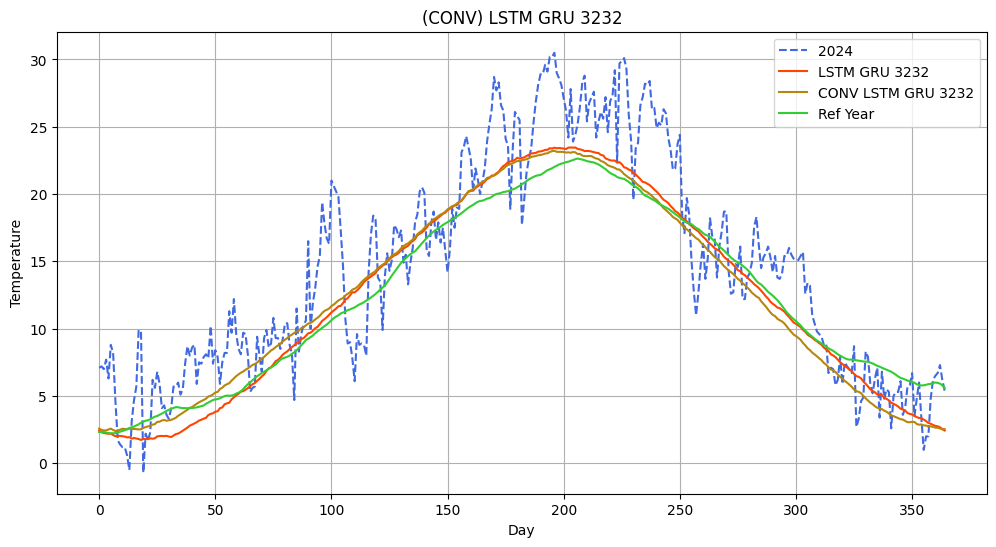

In [59]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_3232[:, 2], label="LSTM GRU 3232", color='orangered')
plt.plot(x, Y_conv_lstm_gru_3232[:, 2], label="CONV LSTM GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [34]:
lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_6464= lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 172.8581 - mae: 10.5905 - val_loss: 89.9482 - val_mae: 7.5507
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 74.2627 - mae: 7.0555 - val_loss: 70.4791 - val_mae: 7.0317
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 65.3901 - mae: 6.7781 - val_loss: 68.8115 - val_mae: 7.0069
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 64.9927 - mae: 6.7710 - val_loss: 68.6846 - val_mae: 7.0063
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 64.9744 - mae: 6.7722 - val_loss: 68.6823 - val_mae: 7.0062
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 64.9468 - mae: 6.7701 - val_loss: 68.7004 - val_mae: 7.0072
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 65.0305 - mae: 6.7747 - val_loss: 68.7020 - val_mae: 7.0073
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 64.9812 - mae: 6.7722 - val_loss: 68.7062 - val_mae: 7.0071
Epoch 9/60
183/183 ━━━━━━━

In [35]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_6464_pred.csv')

mae_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_6464:.3f}')

rmse_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Mean Absolute Error (MAE): 3.176
Root Mean Squared Error (RMSE): 3.811


In [41]:
conv_lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_6464 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 172.8181 - mae: 10.5887 - val_loss: 90.5449 - val_mae: 7.5686
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 74.5805 - mae: 7.0651 - val_loss: 70.5797 - val_mae: 7.0341
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.4609 - mae: 6.7809 - val_loss: 68.8352 - val_mae: 7.0075
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 64.9894 - mae: 6.7713 - val_loss: 68.6830 - val_mae: 7.0063
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 64.9102 - mae: 6.7674 - val_loss: 68.6993 - val_mae: 7.0072
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 65.0250 - mae: 6.7744 - val_loss: 68.6956 - val_mae: 7.0072
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.0444 - mae: 6.7759 - val_loss: 68.6943 - val_mae: 7.0070
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.0262 - mae: 6.7743 - val_loss: 68.7011 - val_mae: 7.0075
Epoch 9/40
183/183 ━━━━━━━━━━━

In [43]:
from tensorflow.keras.models import load_model
conv_lstm_gru_6464 = load_model('models/conv_lstm_gru_6464.keras')
history_conv_lstm_gru_6464_2 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 12.3378 - mae: 2.7423 - val_loss: 13.1596 - val_mae: 2.8803
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.2302 - mae: 2.7293 - val_loss: 12.9856 - val_mae: 2.8615
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.1630 - mae: 2.7214 - val_loss: 13.4125 - val_mae: 2.9073
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 12.0729 - mae: 2.7117 - val_loss: 13.7166 - val_mae: 2.9383
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.0352 - mae: 2.7071 - val_loss: 13.5313 - val_mae: 2.9235
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.9705 - mae: 2.6996 - val_loss: 13.9410 - val_mae: 2.9697
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.9452 - mae: 2.6974 - val_loss: 13.4885 - val_mae: 2.9163
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.8674 - mae: 2.6880 - val_loss: 13.9922 - val_mae: 2.9721
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [7]:
from tensorflow.keras.models import load_model
conv_lstm_gru_6464 = load_model('models/conv_lstm_gru_6464.keras')
history_conv_lstm_gru_6464_3 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 11.7506 - mae: 2.6745 - val_loss: 13.1830 - val_mae: 2.8828
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.7104 - mae: 2.6698 - val_loss: 13.6056 - val_mae: 2.9308
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.7125 - mae: 2.6705 - val_loss: 13.5715 - val_mae: 2.9278
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.6646 - mae: 2.6650 - val_loss: 13.8128 - val_mae: 2.9538
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.6261 - mae: 2.6602 - val_loss: 13.5224 - val_mae: 2.9235
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.6366 - mae: 2.6617 - val_loss: 13.7077 - val_mae: 2.9430
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.5893 - mae: 2.6557 - val_loss: 13.6439 - val_mae: 2.9362
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.5678 - mae: 2.6530 - val_loss: 13.8904 - val_mae: 2.9626
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [8]:
conv_lstm_gru_6464 = tf.keras.models.load_model('models/conv_lstm_gru_6464.keras')

Y_conv_lstm_gru_6464 = conv_lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_6464 = Y_conv_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_6464_pred.csv')

mae_conv_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_6464:.3f}')

rmse_conv_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Mean Absolute Error (MAE): 3.153
Root Mean Squared Error (RMSE): 3.846


In [9]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


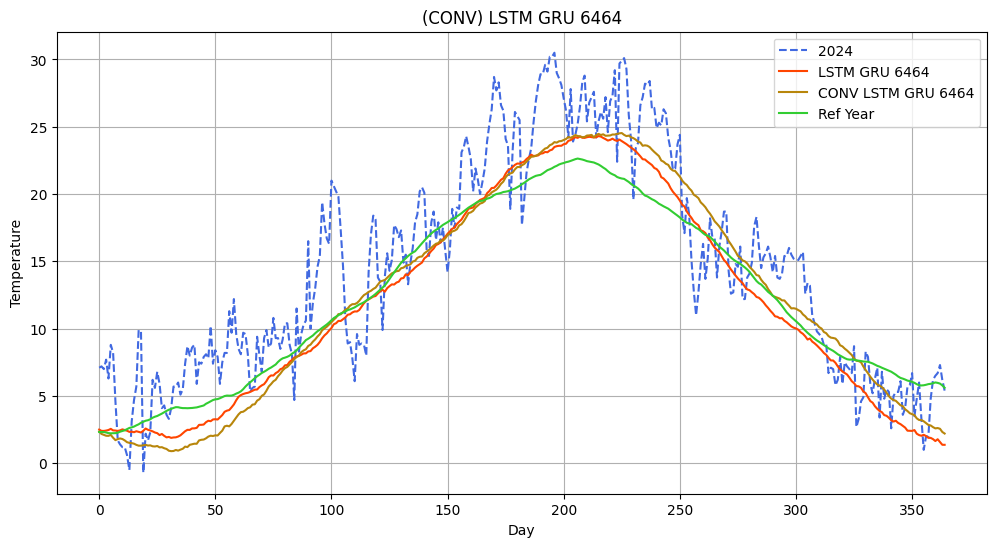

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_6464[:, 2], label="LSTM GRU 6464", color='orangered')
plt.plot(x, Y_conv_lstm_gru_6464[:, 2], label="CONV LSTM GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [48]:
lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_128128= lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 145.1850 - mae: 9.5921 - val_loss: 70.0904 - val_mae: 7.0252
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 65.2853 - mae: 6.7793 - val_loss: 68.7238 - val_mae: 7.0077
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 65.0036 - mae: 6.7730 - val_loss: 68.7161 - val_mae: 7.0081
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 65.0257 - mae: 6.7737 - val_loss: 68.7708 - val_mae: 7.0102
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 64.9645 - mae: 6.7709 - val_loss: 68.8040 - val_mae: 7.0118
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 65.0020 - mae: 6.7720 - val_loss: 68.7931 - val_mae: 7.0101
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 64.6611 - mae: 6.7524 - val_loss: 66.3985 - val_mae: 6.8741
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 62.1407 - mae: 6.6057 - val_loss: 62.6373 - val_mae: 6.6514
Epoch 9/40
183/183 ━━━━━━━━━━

In [49]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')

Y_lstm_gru_128128 = lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_128128 = Y_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_128128_pred.csv')

mae_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_128128:.3f}')

rmse_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Mean Absolute Error (MAE): 3.022
Root Mean Squared Error (RMSE): 3.689


In [50]:
conv_lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_128128 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 144.8470 - mae: 9.5808 - val_loss: 70.2305 - val_mae: 7.0279
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 65.1561 - mae: 6.7719 - val_loss: 68.7553 - val_mae: 7.0088
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 64.9886 - mae: 6.7725 - val_loss: 68.7445 - val_mae: 7.0093
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0404 - mae: 6.7747 - val_loss: 68.7921 - val_mae: 7.0099
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0737 - mae: 6.7760 - val_loss: 68.7678 - val_mae: 7.0100
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 65.0711 - mae: 6.7766 - val_loss: 68.8020 - val_mae: 7.0102
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 65.0259 - mae: 6.7739 - val_loss: 68.7505 - val_mae: 7.0086
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 64.9685 - mae: 6.7701 - val_loss: 68.7540 - val_mae: 7.0086
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [52]:
from tensorflow.keras.models import load_model
conv_lstm_gru_128128 = load_model('models/conv_lstm_gru_128128.keras')
history_conv_lstm_gru_128128_2 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 11.8659 - mae: 2.6891 - val_loss: 12.6353 - val_mae: 2.8263
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.7822 - mae: 2.6788 - val_loss: 12.8420 - val_mae: 2.8506
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.6956 - mae: 2.6688 - val_loss: 12.8201 - val_mae: 2.8472
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.6396 - mae: 2.6623 - val_loss: 12.9911 - val_mae: 2.8673
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 11.5808 - mae: 2.6549 - val_loss: 12.7464 - val_mae: 2.8351
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 11.5330 - mae: 2.6490 - val_loss: 12.9391 - val_mae: 2.8594
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.4780 - mae: 2.6424 - val_loss: 12.7980 - val_mae: 2.8430
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.4181 - mae: 2.6352 - val_loss: 12.8045 - val_mae: 2.8433
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [53]:
conv_lstm_gru_128128 = tf.keras.models.load_model('models/conv_lstm_gru_128128.keras')

Y_conv_lstm_gru_128128 = conv_lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_128128 = Y_conv_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_128128_pred.csv')

mae_conv_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_128128:.3f}')

rmse_conv_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Mean Absolute Error (MAE): 3.106
Root Mean Squared Error (RMSE): 3.783


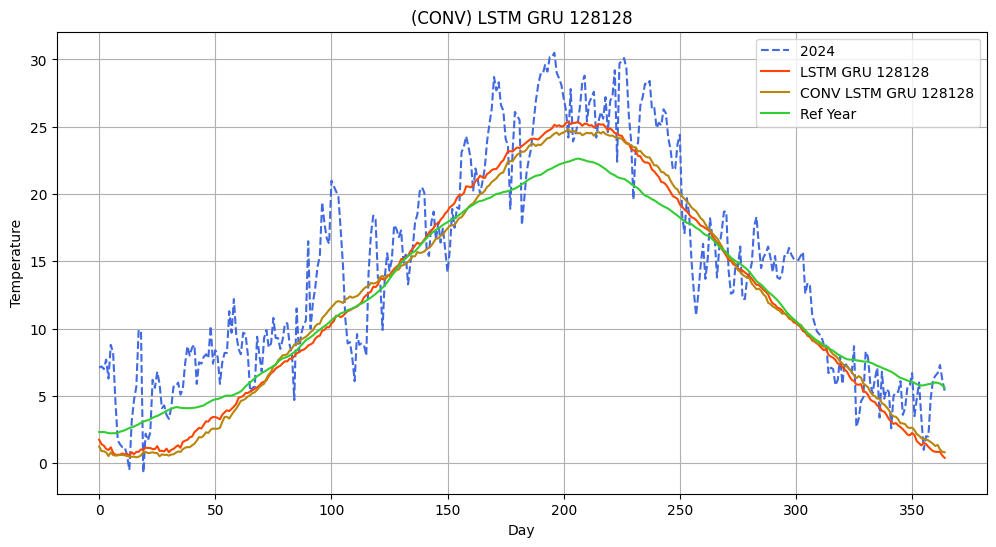

In [54]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_128128[:, 2], label="LSTM GRU 128128", color='orangered')
plt.plot(x, Y_conv_lstm_gru_128128[:, 2], label="CONV LSTM GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 